# Hierarchical Modeling 

For a better `class` definition see [pymc3 example](https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/probabilistic_matrix_factorization.html).

For a tutorial on Hierarchical check out these tutorials from the `pymc3` examples page: 
  - https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-simpsons-paradox.html
  - https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/rugby_analytics.html
  
  
Right now, each posterior predicted per glacier is independent of one another. This isn't the most efficient, nor the most bayesian. We should implement something that's properly hierarchical, but that will mean some reparameterization: 
  - https://stackoverflow.com/questions/48184335/userwarning-pymc3-what-does-reparameterize-mean


In terms of better priors, see: 
  - [Rounce et al. 2020](https://www-cambridge-org.proxy.lib.sfu.ca/core/services/aop-cambridge-core/content/view/61D8956E9A6C27CC1A5AEBFCDADC0432/S0022143019000911a.pdf/quantifying_parameter_uncertainty_in_a_largescale_glacier_evolution_model_using_bayesian_inference_application_to_high_mountain_asia.pdf): _Quantifying parameter uncertainty in a large-scale glacier evolution model using Bayesian
inference: application to High Mountain Asia_

In [1]:
import theano
from theano import pp
import theano.tensor as tt

import glob
import time 
import pymc3 as pm 
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import scipy.stats as st
import matplotlib.pyplot as plt 

In [2]:
Young2020 = xr.open_dataset("../MB_tune/notebooks/Young_etal_2020_Delta_T_-0.9_C.nc")
z_ref  = Young2020.stack(z=('x', 'y')).Elevation.mean().values
A_mean = Young2020.stack(z=('x', 'y')).Accumulation.mean().values

In [3]:
class PDD_melt_model: 
    """ Forward model for our mass balance paramter inversion
    """
    
    def __init__(self, α, T_ma, ΔTΔz, T_p, ref_z, T_m, T_rs, A_mean): 
        self.α      = α       # anual air temp. amplitude    [K]
        self.T_ma   = T_ma    # Mean annual air temp @ ref_z [K]
        self.ΔTΔz   = ΔTΔz    # air temp lapse rate          [K m^-1]
        self.T_p    = T_p     # DOY of annual temp peak      [DOY]
        self.ref_z  = ref_z   # reference surface elevation  [m a.s.l.]
        self.T_m    = T_m     # Melting temp. threshold      [K]
        self.T_rs   = T_rs    # T_
        self.A_mean = A_mean  # Mean annual accum.   @ ref_z [kg m^-2 yr^-1]

        self._compiled = self._compile_forward()
        
    def _air_temp(self, z): 
        doy = np.arange(1,366)[:, np.newaxis]
        return self.α*np.cos( 2*np.pi*(doy-self.T_p)/365 ) + self.ΔTΔz*(self.ref_z-z)+self.T_ma
    
    def tt_forward(self, z, f_snow, C, grad_a, f_r): 
        """Theano implementation of the forward model which supports shared
           variables as input. 
           
             grad_a    (float) --> alititudinal precip factor   [m^-1]

        """
        f_ice = C*f_snow
        T     = self._air_temp(z) #+ T_bias

        PDDs = tt.switch(tt.gt(T, self.T_m), T, 0.0).sum(axis=0) 

        accum_days = tt.switch(tt.lt(T, self.T_rs), 1/365., 0.0).sum(axis=0)  

        # calculate snow accumulation
        A_snow = tt.maximum((accum_days*self.A_mean)*
                          (1+(z-self.ref_z)*grad_a), 0.0)

        # calculate local surface melt assuming f_m = f_snow
        melt_local = PDDs * f_snow

        # calculate refreezing
        R = tt.minimum(f_r*A_snow, melt_local)


        r_s2m = tt.switch(tt.eq(melt_local, 0.0), 1.0, A_snow/melt_local)

        f_m = tt.switch(tt.ge(r_s2m, 1.), f_snow,
                        f_ice - (f_ice - f_snow)*r_s2m)

        # calculate surface melt [kg m^{-2} yr^{-1}] with f_m
        M_melt = f_m*PDDs

        return (A_snow + R - M_melt) * (1/910)
    
    def _compile_forward(self): 
        """Function to compile the theano implementation of the forward model. 
        """
        z      = tt.vector('z')
        f_snow = tt.dscalar('T_m')
        C      = tt.dscalar('C')
        grad_a = tt.dscalar('grad_a')
        f_r    = tt.dscalar('f_r')
        
        compiled = theano.function([z, f_snow, C, grad_a, f_r], 
                            self.tt_forward(z, f_snow, C, grad_a, f_r))
        
        return compiled
    
    def eval_forward(self, z, f_snow, C, grad_a, f_r): 
        """Compiled version of the forward model which takes numeric inputs as
           arguments and output numeric arguments. 
        """
        return self._compiled(z, f_snow, C, grad_a, f_r)

In [4]:
const =  dict(T_m    = 0.0, 
              T_rs   = 1.0,
              A_mean = 1.4 * 910., 
              α      = 10.5, 
              T_ma   = -6.65,
              ΔTΔz   = 6.5E-3, 
              T_p    = 196, 
              ref_z  = 2193)

melt_model = PDD_melt_model(**const)

In [5]:
glacs = [('lilk-a',   '00.1'), 
         ('crmpt18-a','00.2'), 
         ('crmpt12',   -0.3)]

results_fp = "../../initialization/coarse/result/{}/nc/{}_*_{}_OFF*.nc"



dfs = []
for glac in glacs: 
    key, offset = glac
    
    src_fp = glob.glob(results_fp.format(*[key] * 2, offset))[0]
    
    with xr.open_dataset(src_fp) as src: 
        # correct for minimum ice thickness
        src["depth"] = xr.where(src.depth <= 10, 0, src.depth)
        # apply sigma coordinate transform for vertical coordinate
        src["Z"]     = src.zbed + src.Z * src.height 
        # Calculate the magnitude of the velocity vectors
        src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)    
        
    # Exract data of interest from NetCDF file
    z  = src['zs'].isel(t=-1,coord_2=-1).values[np.newaxis, :]
    MB = np.random.normal(src['zs accumulation flux 2'].isel(t=-1,coord_2=-1).values, 1e-1)[np.newaxis, :]
        
    dfs.append(pd.DataFrame({f'z':z[0], "MB": MB[0], 'key':[key]*len(z[0])}))
        
Elmer_Runs = pd.concat(dfs, ignore_index=True)
Elmer_Runs["key_factor"] =  pd.factorize(Elmer_Runs.key)[0]

coords = {"key": Elmer_Runs.key.unique(),
          "idx": np.arange(Elmer_Runs.shape[0])}


In [52]:
# Define "data", which allows hierarchical prediction
with pm.Model(coords=coords) as model: 
    # constant model encapsulated within pandas df
    MB = pm.Data("MB", Elmer_Runs["MB"], dims="idx")
    z  = pm.Data("z",  Elmer_Runs["z"],  dims="idx")
    g  = pm.Data("g",  Elmer_Runs["key_factor"],  dims="idx")
    
# Define Priors
with model: 
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Mass balance Model (physical priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    #---------------------------
    # -> global model parameters
    #---------------------------
    # Somewhat base of Aschwanden et al. 2019
    C_prior    = pm.TruncatedNormal("C",      mu=2.0,  sigma=1.5,  lower=1)
    # Need a reference for the accumulation grad distibution 
    grad_a     = pm.Uniform("grad_a", lower=1e-4, upper=1e-2)
    
    #-------------------------------------
    # -> glacier-specific model parameters
    #-------------------------------------
    # Degree Day factor: Braithwaite (2008) / Rounce et al. 2020
    f_s_prior  = pm.TruncatedNormal("f_s",    mu=4.1,  sigma=0.5,  lower=0.0, dims='key')
    # Somewhat base of Aschwanden et al. 2019
    f_r_prior  = pm.TruncatedNormal('f_r',    mu=0.5,  sigma=0.5,  lower=0.0, upper=1, dims='key')


    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # We should probably account for the error associated with our 
    # mass balance model not able to actually fit the Young et al. results
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ????? 
    
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Hyperparameters (likelihood related priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    sigma      = pm.HalfCauchy("sigma", 10, )    



with model: 
    mu = pm.Deterministic('mu', 
                          melt_model.tt_forward(z, f_s_prior[g], C_prior, grad_a, f_r_prior[g]), 
                          dims='idx')
    
# Define likelihood (function?)  
with model: 
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=MB, dims='idx')
    
# run inference: Sample   
with model: 
    
    prior = pm.sample_prior_predictive()
    
    # obtain starting values via MAP
    # startvals = pm.find_MAP()
    
    trace = pm.sample(draws=500, 
                      tune=1000, 
                      cores=2, 
                      return_inferencedata=True,
                      target_accept=0.99);


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, f_r, f_s, grad_a, C]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 256 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


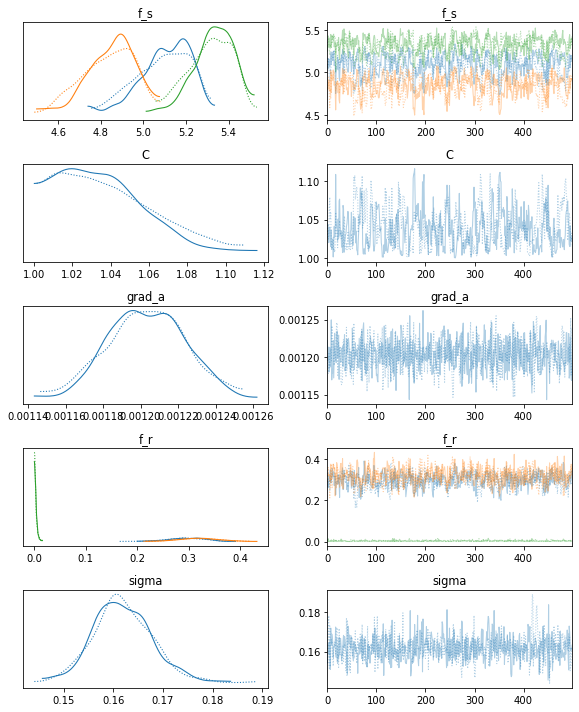

In [53]:
az.plot_trace(trace, 
              var_names=["f_s", "C", "grad_a", "f_r", "sigma"],
              figsize=(8,10));
plt.tight_layout()

In [46]:
# ax = az.plot_pair(
#     trace,
#     var_names=["f_s", "C", "grad_a", "f_r", "sigma"],
#     kind=["scatter", "kde"],
#     kde_kwargs={"fill_last": False},
#     marginals=True,
#     point_estimate="median",
#     figsize=(10, 8),
# )

In [11]:
pm.summary(trace).head(n=9)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
f_s[lilk-a],5.096,0.116,4.890,5.292,0.005,0.004,463.0,646.0,1.01
f_s[crmpt18-a],4.843,0.111,4.646,5.041,0.005,0.004,466.0,700.0,1.00
f_s[crmpt12],5.322,0.095,5.148,5.503,0.004,0.003,518.0,642.0,1.00
C,1.038,0.024,1.000,1.079,0.001,0.001,464.0,699.0,1.01
grad_a,0.001,0.000,0.001,0.001,0.000,0.000,1542.0,1220.0,1.00
f_r[lilk-a],0.295,0.034,0.234,0.363,0.001,0.001,805.0,946.0,1.00
f_r[crmpt18-a],0.319,0.036,0.252,0.387,0.001,0.001,831.0,1095.0,1.00
f_r[crmpt12],0.003,0.003,0.000,0.008,0.000,0.000,1076.0,822.0,1.00
sigma,0.162,0.006,0.150,0.174,0.000,0.000,1545.0,1397.0,1.00


In [12]:
with model: 
    ppc = pm.sample_posterior_predictive(
    trace, var_names=["f_s", "C", "grad_a", "f_r", "sigma", "Y_obs"])

# post_samples = np.stack([ppc[key] for key in list(ppc)[:-1]])

In [27]:
samples = [ppc[key] for key in list(ppc)[:-1]]

In [33]:
len(ppc['sigma'].shape)

1

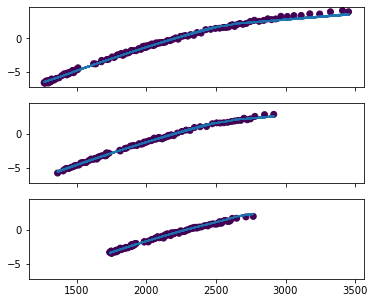

In [45]:
fig, ax = plt.subplots(3,1, figsize=(6,5),
                       sharex=True, sharey=True)

for j in [0,1,2]:
    sub_df = Elmer_Runs[Elmer_Runs['key_factor']==j]
    
    for i in np.random.randint(0,1999,499):
        params = []
                
        for key in list(ppc)[:-2]: 
            if len(ppc[key].shape) == 2: 
                params.append(ppc[key][i, j])
            else: 
                params.append(ppc[key][i])
        
        ax[j].plot(sub_df.z.values, 
                   melt_model.eval_forward(sub_df.z.values, *params), 
                   c='tab:blue', 
                   alpha=0.1)
        
    ax[j].scatter(sub_df.z, sub_df.MB, c=sub_df.key_factor)

    


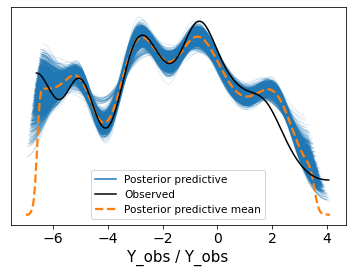

In [16]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model));